# Network Science
## Final Project

### What happens with robustness in the presence of interdependent networks?

#### Ben Murphy 16-714-925
#### Florian Rüegsegger 16-714-737
#### Silvan Wehrli 15-703-275

## Introduction

We analyse the streetnetwork of Newyork/Manhattan in order to find where weakpoints of the system lie. In order to confirm our findings we define metrics by which we measure the speed at which cars can traverse through the network. 

- Randomly select two nodes and check how long it takes from Node A to B
- check average path length
- define metrics speed (Use edge attributes) (speedlimit, distance, time), (amount of nodes), (traffic?/real traffic data)
- simulate traffic
- compare to real traffic data
- randomly attack network in order to verify our choice of nodes
- try with other networks? Zurich?
- 


In [1]:
import networkx as nx
from networkx import read_graphml
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
import seaborn as sns
import osmnx as ox
import random
from tqdm.notebook import tqdm
import time

LOAD = False

### Plotting functions

In [7]:
def plot_hist(data: List[float], title: str,label: str, xlabel: str = "", density=True, show=True):
    plt.hist(data, label=label, density=density)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f"{'density' if density else 'count'} ")
    if show:
        plt.legend()
        plt.show()
    

## General Data

In [5]:
def clean_data(graph, key_for_removal: str) -> nx.Graph:
    
    new_graph = nx.DiGraph()
    new_graph.graph = graph.graph
    for edge in graph.edges():
        start, end = edge
        keys = graph[start][end][key_for_removal].keys()
        data = {}
        for key in keys:
            if key in ["highway","name", "lanes","maxspeed","Bridge","Tunnel", "length", "speed_kph", "travel_time"]:
                data[key] = graph[start][end][key_for_removal][key]
                if key == "length":
                    data[key] = float(data[key])
        new_graph.add_edge(start,end,**data)

    for node in graph.nodes().keys():
        for key in graph.nodes()[node].keys():
            if key in ["x", "y"]: 
                new_graph.nodes()[node][key] = float(graph.nodes()[node][key])
            elif key == "highway":
                new_graph.nodes()[node][key] = graph.nodes()[node][key]

                
    return new_graph    




In [101]:
if LOAD:
    print("Downloading data")
    graph = ox.graph_from_place('New York, USA', network_type='drive')
    print("adding the need for speed")
    graph = ox.speed.add_edge_speeds(graph)
    graph = ox.speed.add_edge_travel_times(graph, precision=1)
    print("Writing uncleaned to file")
    ox.save_graphml(graph, "data/unclean_and_tainted.graphml")
    print("Cleaning data")
    graph = clean_data(graph,0)
    print("write to file")
    nx.write_gml(graph,"data/osmnx_cleaned.gml")
graph = nx.read_gml("data/osmnx_cleaned.gml")

## Data Inspection

In [62]:
uncleaned_graph = ox.load_graphml("data/unclean_and_tainted.graphml")

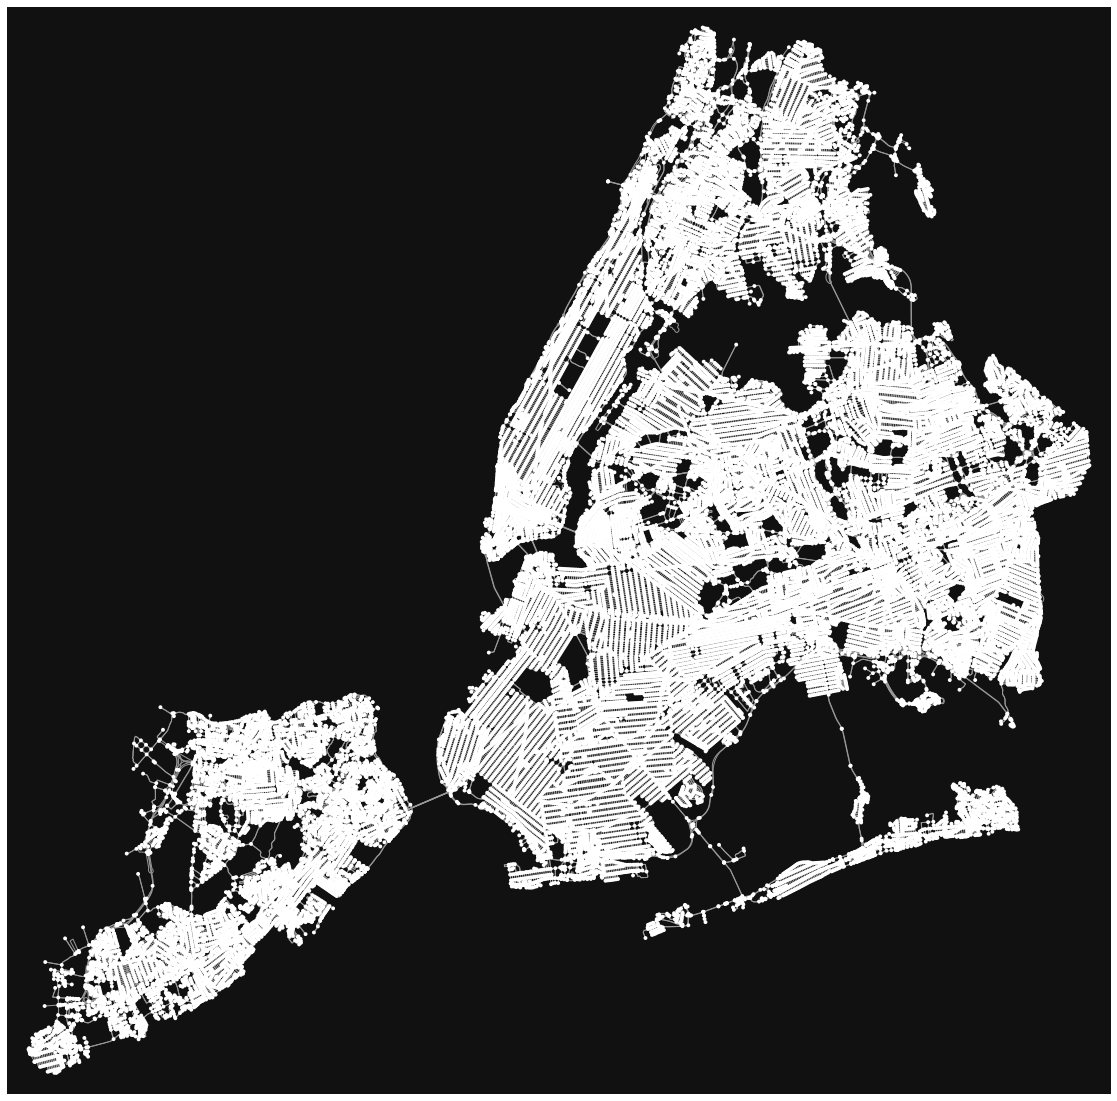

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [78]:
ox.plot_graph(uncleaned_graph, figsize=(20,20))

In [99]:
bot_left = {
    "node":None,
    "x":0,
    "y":90
}
top_right = {
    "node":None,
    "x": -90,
    "y": 0
    }

for node in uncleaned_graph.nodes():
    n = uncleaned_graph.nodes()[node]
    n["color"] = "w"
    if n['x']< bot_left["x"]  and n["y"] < bot_left["y"]:
        bot_left["node"] = node
        bot_left["x"] = n["x"]
        bot_left["y"] = n["y"]
    if n['x'] > top_right["x"] and n["y"] > top_right["y"]:
        top_right["node"] = node
        top_right["x"] = n["x"]
        top_right["y"] = n["y"]



In [104]:
print(bot_left)
print(top_right)
path = nx.shortest_path(uncleaned_graph,bot_left["node"], top_right["node"], weight="travel_time")
path2 = nx.shortest_path(uncleaned_graph,bot_left["node"], top_right["node"])


{'node': 42947240, 'x': -74.254901, 'y': 40.507704}
{'node': 42732060, 'x': -73.7827332, 'y': 40.8480932}


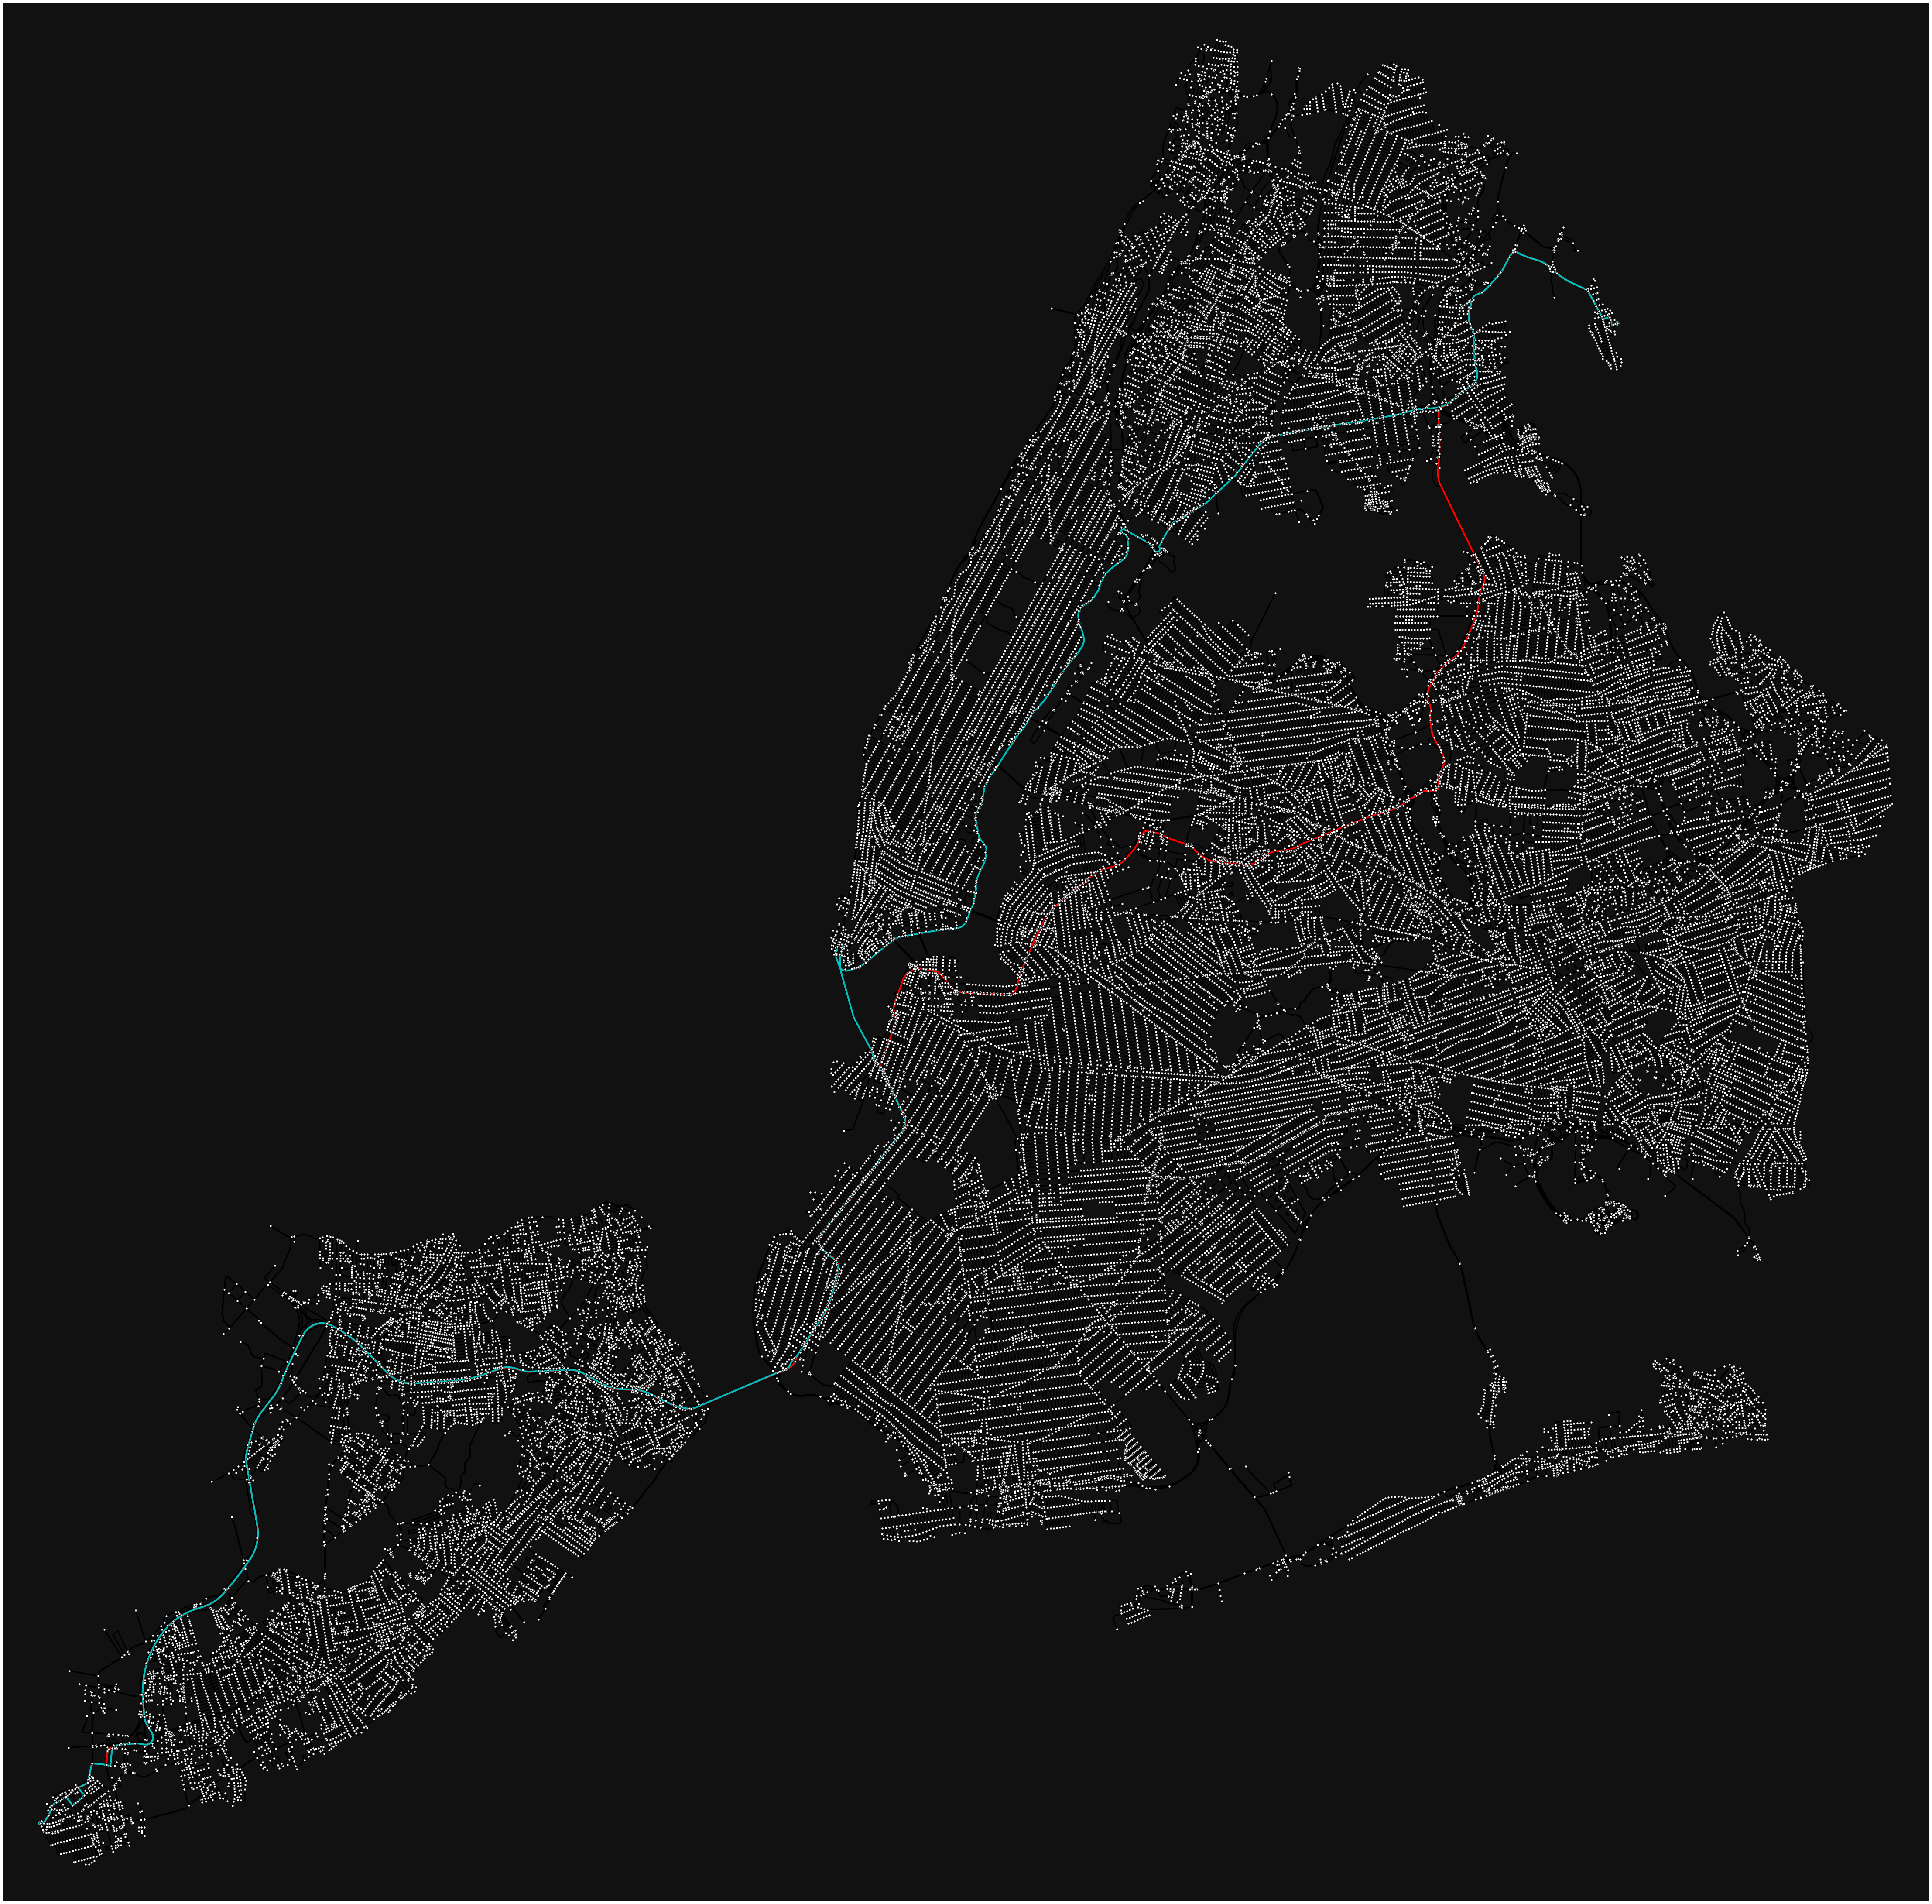

In [106]:
routes_color = ["r", "c"]
routes = [path,path2]
fig, ax = ox.plot_graph_routes(uncleaned_graph,routes, route_colors=routes_color, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color="k", edge_linewidth=3, figsize=(80,80), route_linewidth=10, route_alpha=1)

In [ ]:
uncleaned_graph

In [15]:
print(f"n nodes: {len(graph.nodes())}")
print(f"n edges: {len(graph.edges())}")
print(f"graph is directed: {nx.is_directed(graph)}")
print(f"graph weakly connected: {nx.is_weakly_connected(graph)}") # Treat edges as undirected
print(f"graph strongly connected: {nx.is_strongly_connected(graph)}") # Treat edges as directed

n nodes: 55366
n edges: 140022
graph is directed: True
graph weakly connected: True
graph strongly connected: False


### Component analysis

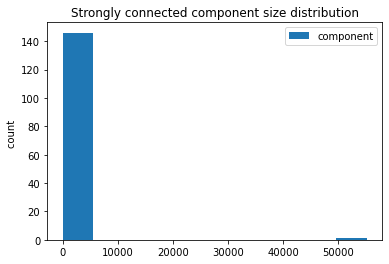

In [16]:
component_size = np.array([len(value) for index, value in enumerate(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))])
plot_hist(component_size, "Strongly connected component size distribution", "component", density=False)

We have a lot of small unconnected components (strong connectivity)

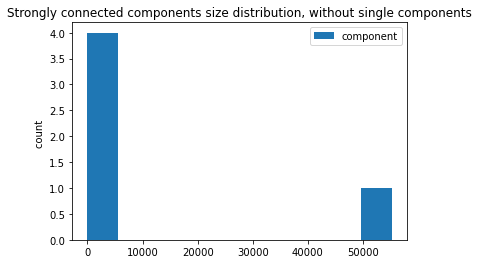

In [17]:
plot_hist(component_size[component_size>1], "Strongly connected components size distribution, without single components", "component", density=False)

By removing all components with size < 2 we end up with 9 components.  
Suggestion: Remove all components except the big one, since the small ones hardly matter

In [3]:
largest_component = list(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))[0]
graph = graph.subgraph(largest_component)

In [19]:

print(f"n nodes: {len(graph.nodes())}")
print(f"n edges: {len(graph.edges())}")
print(f"graph is directed: {nx.is_directed(graph)}")
print(f"graph weakly connected: {nx.is_weakly_connected(graph)}") # Treat edges as undirected
print(f"graph strongly connected: {nx.is_strongly_connected(graph)}") # Treat edges as directed

n nodes: 55216
n edges: 139814
graph is directed: True
graph weakly connected: True
graph strongly connected: True


### degree distribution

In [36]:
from scipy.special import factorial
import powerlaw
degrees = [i[1] for i in graph.degree()]
deg_mean = np.mean(degrees)
spacing = np.linspace(np.min(degrees), np.max(degrees), np.max(degrees)-np.min(degrees))
poisson = ((deg_mean**spacing) / factorial(spacing) ) * np.exp(-deg_mean)
#poisson = np.random.poisson(spacing)
degrees = np.array(degrees)
exponential = deg_mean**-1 * np.exp(-spacing / deg_mean) 
fit = powerlaw.Fit(degrees)

[0.08102568 0.14286936 0.17706272 0.16785607 0.12818599 0.08166136
 0.0445053  0.02114929 0.00889485]
Calculating best minimal value for power law fit


/home/flo/anaconda3/envs/network_science/lib/python3.9/site-packages/powerlaw.py:1188: RuntimeWarning: overflow encountered in double_scalars
  return (self.alpha-1) * self.xmin**(self.alpha-1)
/home/flo/anaconda3/envs/network_science/lib/python3.9/site-packages/powerlaw.py:835: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


<AxesSubplot:>

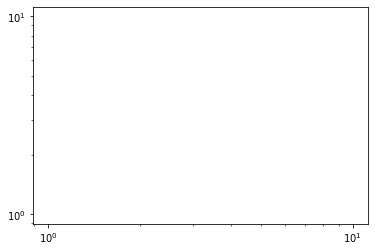

In [47]:
fit.power_law.plot_pdf(label="powerlaw")
#fit.pdf()

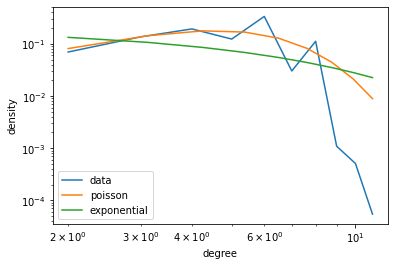

In [50]:
from collections import Counter
degrees = [i[1] for i in graph.degree()]
#plot_hist(degrees, "Degree distribution", "degree", "degree", show=False)
counts = Counter(degrees)

keys = sorted(counts.keys())
values = [counts[key] / len(degrees) for key in keys]
plt.plot(keys,values, label="data")
plt.plot(spacing,poisson, label="poisson")
plt.plot(spacing,exponential, label="exponential")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("degree")
plt.ylabel("density")
plt.legend()
plt.show()

In [ ]:
in_degrees = [i[1] for i in graph.in_degree()]
plot_hist(in_degrees, "In-Degree distribution", "in_degree", "in_degree")

In [ ]:

out_degrees = [i[1] for i in graph.out_degree()]
plot_hist(out_degrees, "Out-Degree distribution", "out_degree", "out_degree")

In [ ]:
degrees = {
    "in_degrees":in_degrees,
    "out_degrees":out_degrees
}
sns.jointplot(x="in_degrees",y="out_degrees",data=degrees, size=8)


### Assortativity

In [ ]:
rand_graph = nx.directed_configuration_model(dict(graph.in_degree()).values(), dict(graph.out_degree()).values(), seed=128)
print(f"graph degree assortativity: {nx.degree_assortativity_coefficient(graph)}")
print(f"Random graph degree assortativity: {nx.degree_assortativity_coefficient(rand_graph)}")


In [ ]:
print(f"graph density: {nx.density(graph)}")
print(f"rand graph density: {nx.density(rand_graph)}")

In [ ]:
shortest = nx.shortest_path(graph,"43010059","42485784")
shortest_lenght = nx.shortest_path(graph,"43010059","42485784", weight="travel_time")


In [ ]:
graph["42467330"]["42510401"]

In [ ]:
# calculate weights
# include speed_limit, distance, (amount of lanes, (time of day/traffic)),
# calculate weight by looking at neighbouring nodes
# Time = distance / speed_limit
# Weight = (Time - min(Time)) / (max(time) - min(time)) # standardise to get values between (0,1)
# lower weight => less time => better route



In [ ]:
graph["43010059"]["42997670"]

In [111]:
speeds = {}
for edge in graph.edges():
    start, end = edge
    speed = graph[start][end]["speed_kph"]
    if speed in speeds:
        speeds[speed] += 1
    else:
        speeds[speed] = 1
        

In [112]:
speeds

{64.6: 1544,
 80.5: 554,
 40.2: 26333,
 48.3: 1292,
 41.6: 13558,
 37.7: 85609,
 42.5: 5681,
 41.0: 389,
 32.2: 2701,
 75.9: 474,
 64.4: 100,
 49.3: 266,
 43.1: 100,
 32.0: 2,
 36.4: 296,
 33.2: 163,
 56.0: 3,
 24.1: 78,
 16.1: 38,
 6.4: 2,
 14.1: 23,
 8.0: 3,
 25.0: 60,
 56.3: 309,
 72.4: 149,
 36.0: 5,
 44.0: 8,
 42.4: 4,
 76.0: 12,
 84.0: 4,
 88.5: 15,
 50.0: 16,
 72.0: 2,
 48.0: 3,
 52.0: 12,
 40.0: 1,
 80.0: 2,
 60.0: 1,
 59.0: 1,
 68.0: 1}

### 

### Percolation / Robustness
#### How does the size of largest component change when nodes/links are removed?
3 Strategies:
- strategy 1: remove nodes randomly
<br>idea: baseline
- strategy 2: 
<br>(a) remove nodes with the highest betweenness centrality (unweigthed)
<br> (b) remove nodes with the highest betweenness centrality (weighted: travel time)
<br>idea: target nodes that are important routes for all routes through the city
- strategy 3: remove links with low travel times
<br>idea: target links (streets) that allow to travel especially fast through the city

check for enhanced robustness

In [60]:
degrees = np.array([value for _, value in graph.degree()])
mean_degree = np.mean(degrees)
exp_mean_degree = np.mean(degrees**2)
print(f"<k^2>: {exp_mean_degree}")
print(f"<k>(<k>+1): {mean_degree * (mean_degree+1)}")
print(f"<k^2> > <k>(<k>+1): {exp_mean_degree > mean_degree * (mean_degree+1)}")
#exp_mean_degree > mean_degree * (mean_degree+1)

<k^2>: 28.499166908142566
<k>(<k>+1): 30.710953037226638
<k^2> > <k>(<k>+1): False


In [45]:
STEP_SIZE = 20

In [179]:
def robustness(graph, removal_mode='random', link_attribute=None, step_size=STEP_SIZE, show_progress=True):
    if removal_mode == 'random':
        removal_order = random.sample(graph.nodes(), graph.number_of_nodes())
        
    elif removal_mode == 'betweenness_centrality':
        k = int(graph.number_of_nodes()*0.05) # only consider 5% of the nodes as sample for calculation
        bc = nx.algorithms.centrality.betweenness_centrality(graph, k=k, weight=link_attribute)
        removal_order = [i[0] for i in sorted(bc.items(), key=lambda x: x[1], reverse=True)]
        
    elif removal_mode == 'edge':
        if link_attribute:
            removal_order = sorted(list(graph.edges()), key=lambda x: graph[x[0]][x[1]][link_attribute])
        else:
            removal_order = random.sample(graph.edges(), graph.number_of_edges())
            
    else:
        raise Exception(f"removal mode: {removal_mode} not supported")
        
    graph_copy = graph.copy()
    size_largest_comp = [len(sorted(nx.strongly_connected_components(graph_copy), key=len, reverse=True)[0])]
    
    if show_progress:
        if removal_mode == 'weighted_link':
            pbar = tqdm(total=graph.number_of_edges()//STEP_SIZE)
        else:    
            pbar = tqdm(total=graph.number_of_nodes()//STEP_SIZE)

    for i, e in enumerate(removal_order):
        if removal_mode == 'weighted_link':
            graph_copy.remove_edge(e[0], e[1])
        else:
            graph_copy.remove_node(e)

        if i % STEP_SIZE == 0:
            largest_component = list(sorted(nx.strongly_connected_components(graph_copy), key=len, reverse=True))[0]

            size_largest_comp.append(len(largest_component))
            
            if show_progress:
                pbar.update(1)
    
    return size_largest_comp

#### strategy 1: random node removal

#### real network

In [69]:
size_largest_comp_random = robustness(graph)

  0%|          | 0/2760 [00:00<?, ?it/s]

#### Erdős–Rényi graph

In [78]:
avg_deg_graph = sum([value for _, value in graph.degree()])/graph.number_of_nodes()
p = avg_deg_graph/graph.number_of_nodes()
er_graph = nx.generators.random_graphs.erdos_renyi_graph(n=graph.number_of_nodes(), p=p, directed=True)

In [79]:
er_size_largest_comp_random = robustness(er_graph)

  0%|          | 0/2760 [00:00<?, ?it/s]

In [95]:
steps = np.arange(0, 1, 1/len(size_largest_comp_random))

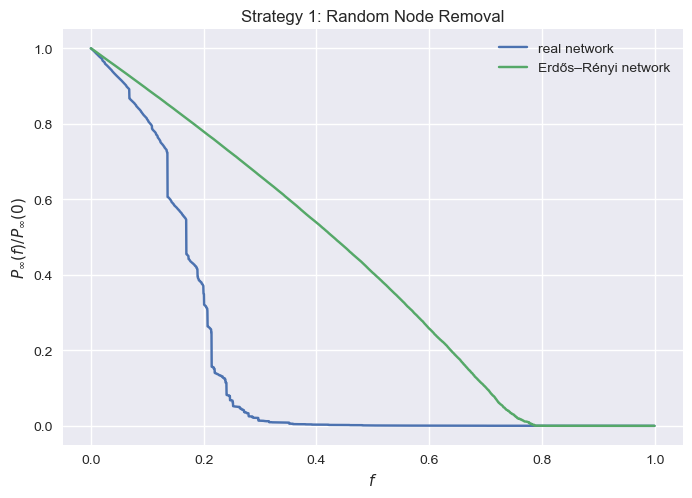

In [110]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 1: Random Node Removal')
plt.plot(steps, [s/size_largest_comp_random[0] for s in size_largest_comp_random], label='real network')
plt.plot(steps, [s/er_size_largest_comp_random[0] for s in er_size_largest_comp_random], label='Erdős–Rényi network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### strategy 2: remove nodes with the highest betweenness centrality

#### (a) unweighted

#### real network

In [180]:
start = time.time()
size_largest_comp_bc = robustness(graph, removal_mode='betweenness_centrality', link_attribute=None)
end = time.time()
print((end - start)/60) # in minutes

  0%|          | 0/2760 [00:00<?, ?it/s]

45.06473998626073


#### Erdős–Rényi graph

In [181]:
er_size_largest_comp_bc = robustness(er_graph, removal_mode='betweenness_centrality', link_attribute=None)

  0%|          | 0/2760 [00:00<?, ?it/s]

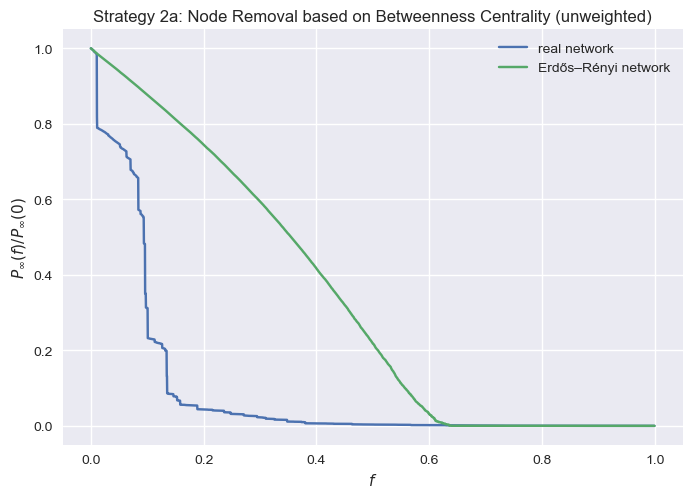

In [182]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 2a: Node Removal Based on Betweenness Centrality (unweighted)')
plt.plot(steps, [s/size_largest_comp_bc[0] for s in size_largest_comp_bc], label='real network')
plt.plot(steps, [s/er_size_largest_comp_bc[0] for s in er_size_largest_comp_bc], label='Erdős–Rényi network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### (b) weighted with travel time

#### real network

In [183]:
size_largest_comp_bcw = robustness(graph, removal_mode='betweenness_centrality', link_attribute='travel_time')

  0%|          | 0/2760 [00:00<?, ?it/s]

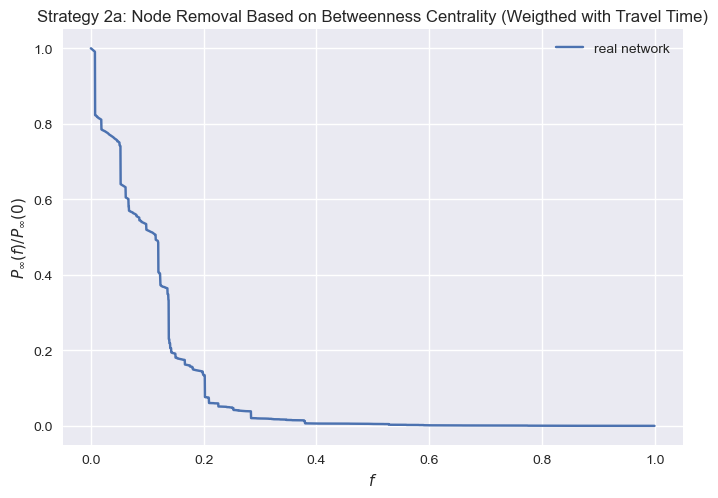

In [185]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 2a: Node Removal Based on Betweenness Centrality (Weigthed with Travel Time)')
plt.plot(steps, [s/size_largest_comp_bcw[0] for s in size_largest_comp_bcw], label='real network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### strategy 3: remove links with low travel times

#### real network

In [143]:
size_largest_comp_tt = robustness(graph, removal_mode='edge', link_attribute='travel_time')

  0%|          | 0/6990 [00:00<?, ?it/s]

In [144]:
steps_links = np.arange(0, 1, 1/len(size_largest_comp_tt))

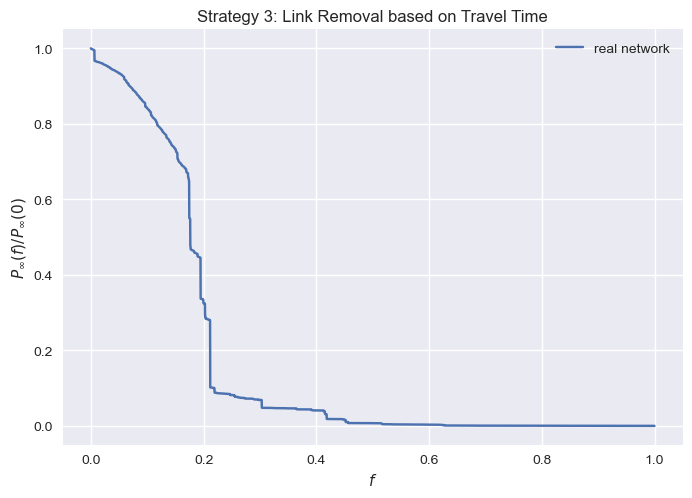

In [146]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 3: Edge Removal Based on Travel Time')
plt.plot(steps_links, [s/size_largest_comp_tt[0] for s in size_largest_comp_tt], label='real network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### strategy comparison for the real network

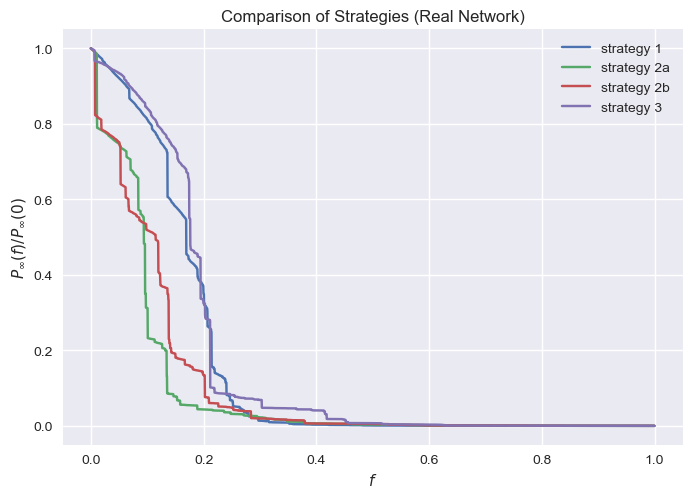

In [186]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Comparison of Strategies (Real Network)')
plt.plot(steps, [s/size_largest_comp_random[0] for s in size_largest_comp_random], label='strategy 1')
plt.plot(steps, [s/size_largest_comp_bc[0] for s in size_largest_comp_bc], label='strategy 2a')
plt.plot(steps, [s/size_largest_comp_bcw[0] for s in size_largest_comp_bcw], label='strategy 2b')
plt.plot(steps_links, [s/size_largest_comp_tt[0] for s in size_largest_comp_tt], label='strategy 3')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()